# Отчёт (Jupyter Notebook): Аппроксимация зависимости прибыли от скидки полиномами 2-й и 3-й степени

1. Загрузка данных `x, y` из `data2.csv` (NumPy).
2. Диагностика данных (размеры, первые строки, NaN).
3. Формирование СЛУ для полинома 2-й степени (3 опорные точки), решает через `scipy.linalg.solve` (или `numpy.linalg.solve`).
4. Построение графиков: исходные точки и подгонка полиномом 2-й степени; считает RSS.
5. Повторение для полинома 3-й степени (4 опорные точки); считает RSS.
6. Сравнение модели по RSS и прогноз прибыли при скидках 6% и 8%.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
print('NumPy:', np.__version__)
try:
    import scipy
    from scipy.linalg import solve as scipy_solve
    print('SciPy:', scipy.__version__)
    HAVE_SCIPY = True
except Exception:
    print('SciPy не найден — будет использован numpy.linalg.solve')
    HAVE_SCIPY = False


NumPy: 2.3.3
SciPy: 1.16.2


## 1. Загрузка данных

In [3]:
# Укажите путь к данным. По умолчанию ищем 'data2.csv' рядом с блокнотом.
path = 'data2.csv'

# Если у вас есть заголовки в первой строке, поменяйте skip_header на 1 и извлеките только числовые столбцы.
try:
    data = np.genfromtxt(path, delimiter=';', skip_header=0)
    if data.ndim != 2 or data.shape[1] < 2:
        raise ValueError('Ожидается как минимум 2 столбца (x, y). Получено shape=' + str(data.shape))
    x = data[:, 0].astype(float)
    y = data[:, 1].astype(float)
except Exception as e:
    raise RuntimeError(f'Не удалось прочитать файл {path}: {e}')

# Сортируем по x на случай неупорядоченных данных
ord_idx = np.argsort(x)
x = x[ord_idx]
y = y[ord_idx]

print('Всего наблюдений:', len(x))
print('Первые 5 строк (x, y):')
print(np.c_[x[:5], y[:5]])

# Базовые проверки
print('Есть ли NaN в x:', np.isnan(x).any())
print('Есть ли NaN в y:', np.isnan(y).any())
if len(x) < 4:
    raise ValueError('Для задачи нужно ≥ 4 наблюдений.')


Всего наблюдений: 26
Первые 5 строк (x, y):
[[ 0.2        -6.57266488]
 [ 0.4        -5.37046782]
 [ 0.6        -3.15858504]
 [ 0.8        -1.48270657]
 [ 1.         -0.12384439]]
Есть ли NaN в x: True
Есть ли NaN в y: False


## 2. Вспомогательные функции

In [6]:
def pick_indices_quadratic(n: int):
    """Равномерный выбор 3 опорных индексов: начало, середина, конец."""
    idx = [0, n//2, n-1]
    idx = sorted(set(idx))
    # На случай маленького n обеспечим 3 уникальных
    k = 0
    while len(idx) < 3 and k < n:
        if k not in idx:
            idx.append(k)
        k += 1
    return sorted(idx[:3])

def pick_indices_cubic(n: int):
    """Равномерный выбор 4 опорных индексов: начало, 1/3, 2/3, конец."""
    idx = [0, n//3, (2*n)//3, n-1]
    idx = sorted(set(idx))
    k = 0
    while len(idx) < 4 and k < n:
        if k not in idx:
            idx.append(k)
        k += 1
    return sorted(idx[:4])

def solve_linear_system(A, b):
    """Решение СЛУ через SciPy (если доступен) или NumPy."""
    if 'HAVE_SCIPY' in globals() and HAVE_SCIPY:
        return scipy_solve(A, b, assume_a='gen', check_finite=False)
    return np.linalg.solve(A, b)

def rss(y_true, y_pred):
    return np.sum((y_true - y_pred)**2)

def eval_poly_quad(coefs, x):
    a2, a1, a0 = coefs
    return a2*x**2 + a1*x + a0

def eval_poly_cubic(coefs, x):
    a3, a2, a1, a0 = coefs
    return a3*x**3 + a2*x**2 + a1*x + a0
def _ensure_finite_unique_points(xp, yp, need):
    # выбросим нефинитные
    m = np.isfinite(xp) & np.isfinite(yp)
    xp, yp = xp[m], yp[m]
    # гарантируем уникальные x (оставим первое вхождение)
    _, uniq_idx = np.unique(xp, return_index=True)
    xp, yp = xp[uniq_idx], yp[uniq_idx]
    if len(xp) < need:
        raise ValueError(f"Недостаточно валидных/уникальных опорных точек: нужно {need}, есть {len(xp)}")
    return xp, yp

def _as_float64_c(a):
    a = np.ascontiguousarray(a, dtype=np.float64)
    return a

def solve_poly_by_points(xp, yp, degree):
    # готовим СЛУ Ax=b
    if degree == 2:
        need = 3
        xp, yp = _ensure_finite_unique_points(xp, yp, need)
        A = np.column_stack([xp**2, xp, np.ones_like(xp)])
    elif degree == 3:
        need = 4
        xp, yp = _ensure_finite_unique_points(xp, yp, need)
        A = np.column_stack([xp**3, xp**2, xp, np.ones_like(xp)])
    else:
        raise ValueError("degree должен быть 2 или 3")

    A = _as_float64_c(A)
    b = _as_float64_c(yp)

    # сначала точное решение
    try:
        if 'HAVE_SCIPY' in globals() and HAVE_SCIPY:
            coefs = scipy_solve(A, b, assume_a='gen', check_finite=True)
        else:
            coefs = np.linalg.solve(A, b)
        # проверка на нереальные значения
        if not np.all(np.isfinite(coefs)):
            raise ValueError("Получены нечисловые коэффициенты")
        return coefs
    except Exception:
        # МНК по всем точкам (устойчиво), если точное не получилось
        # строим Вандермонду под ВСЕ x
        if degree == 2:
            V = np.column_stack([x**2, x, np.ones_like(x)])
        else:
            V = np.column_stack([x**3, x**2, x, np.ones_like(x)])
        coefs, *_ = np.linalg.lstsq(_as_float64_c(V), _as_float64_c(y), rcond=None)
        return coefs

In [8]:
def pick_unique_support(x_all, y_all, k):
    """
    Выбирает k равномерно разбросанных по индексу ОТЛИЧАЮЩИХСЯ по x точек с валидными (finite) x,y.
    Если целевая позиция даёт дубликат x — расширяем окно поиска вокруг неё.
    """
    n = len(x_all)
    if n == 0:
        raise ValueError("Пустой набор данных.")
    # маска валидности
    valid = np.isfinite(x_all) & np.isfinite(y_all)
    xv, yv = x_all[valid], y_all[valid]
    idx_map = np.nonzero(valid)[0]  # соответствие в исходных индексах

    if len(xv) < k:
        raise ValueError(f"Недостаточно валидных наблюдений: нужно {k}, есть {len(xv)}")

    # целевые якоря (равномерно по индексу)
    anchors = np.linspace(0, len(xv)-1, k).astype(int)

    chosen = []
    used_x = set()
    for a in anchors:
        # двунаправленный поиск вокруг якоря
        L = R = a
        picked = None
        while L >= 0 or R < len(xv):
            for pos in (L, R) if L != R else (L,):
                if 0 <= pos < len(xv):
                    xtry = xv[pos]
                    if xtry not in used_x:
                        picked = pos
                        break
            if picked is not None:
                break
            L -= 1; R += 1
        if picked is not None:
            chosen.append(picked)
            used_x.add(xv[picked])
        # если вдруг всё равно не нашли (все дубликаты) — добавим позже из уникальных

    # добираем недостающее из списка уникальных x (по первым вхождениям)
    if len(chosen) < k:
        uniq_x, first_idx = np.unique(xv, return_index=True)
        # снимем уже выбранные
        pool = [i for i in first_idx if xv[i] not in used_x]
        for i in pool:
            chosen.append(i)
            used_x.add(xv[i])
            if len(chosen) == k:
                break

    if len(chosen) < k:
        raise ValueError(f"После устранения дубликатов по x удалось набрать только {len(chosen)} из {k} опорных точек.")

    chosen = sorted(chosen)
    return idx_map[np.array(chosen, dtype=int)]  # индексы относительно исходных x,y


def solve_poly_by_points_from_indices(x_all, y_all, idx, degree):
    Xp, Yp = x_all[idx], y_all[idx]
    # формируем СЛУ
    if degree == 2:
        A = np.column_stack([Xp**2, Xp, np.ones_like(Xp)])
    elif degree == 3:
        A = np.column_stack([Xp**3, Xp**2, Xp, np.ones_like(Xp)])
    else:
        raise ValueError("degree должен быть 2 или 3")
    A = np.ascontiguousarray(A, dtype=np.float64)
    b = np.ascontiguousarray(Yp, dtype=np.float64)

    # пробуем точное решение
    try:
        from scipy.linalg import solve as scipy_solve
        coefs = scipy_solve(A, b, assume_a='gen', check_finite=True)
    except Exception:
        coefs = np.linalg.solve(A, b)

    # страховка: если внезапно вырождено, уйти в МНК по всем точкам
    if not np.all(np.isfinite(coefs)):
        V = (np.column_stack([x_all**2, x_all, np.ones_like(x_all)]) if degree == 2
             else np.column_stack([x_all**3, x_all**2, x_all, np.ones_like(x_all)]))
        coefs, *_ = np.linalg.lstsq(np.ascontiguousarray(V, np.float64),
                                    np.ascontiguousarray(y_all, np.float64), rcond=None)
    return coefs

## 3. Полином 2-й степени: СЛУ → решение → график → RSS

Опорные индексы квадрата: [ 0 12 24]
Опорные точки (x,y): [(np.float64(0.2), np.float64(-6.572664883)), (np.float64(2.6), np.float64(17.26743396)), (np.float64(5.0), np.float64(25.23920411))]
Коэффициенты [a2, a1, a0]: [-1.37745909 13.79025996 -9.27561851]
RSS (квадратичный): nan


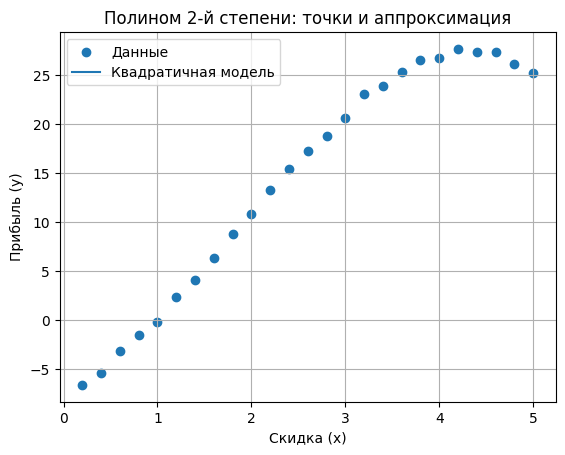

In [9]:
# === Квадратичная модель ===
idx_q = pick_unique_support(x, y, k=3)              # <- было pick_indices_quadratic(n)
coefs_q = solve_poly_by_points_from_indices(x, y, idx_q, degree=2)  # <- вместо solve_poly_by_points(xq, yq, ...)
y_fit_q = eval_poly_quad(coefs_q, x)
rss_q = rss(y, y_fit_q)

print('Опорные индексы квадрата:', idx_q)
print('Опорные точки (x,y):', list(zip(x[idx_q], y[idx_q])))
print('Коэффициенты [a2, a1, a0]:', coefs_q)
print('RSS (квадратичный):', rss_q)

# График — исходные данные и кривая модели
plt.figure()
plt.scatter(x, y, label='Данные')
xx = np.linspace(x.min(), x.max(), 400)
plt.plot(xx, eval_poly_quad(coefs_q, xx), label='Квадратичная модель')
plt.xlabel('Скидка (x)')
plt.ylabel('Прибыль (y)')
plt.title('Полином 2-й степени: точки и аппроксимация')
plt.legend()
plt.grid(True)
plt.show()

## 4. Полином 3-й степени: СЛУ → решение → график → RSS

Опорные индексы куба: [ 0  8 16 24]
Опорные точки (x,y) для кубика: [(np.float64(0.2), np.float64(-6.572664883)), (np.float64(1.8), np.float64(8.822915493)), (np.float64(3.4), np.float64(23.92053257)), (np.float64(5.0), np.float64(25.23920411))]
Коэффициенты [a3, a2, a1, a0]: [-0.54854257  2.90393393  5.81106484 -7.84664687]
RSS (кубический): nan


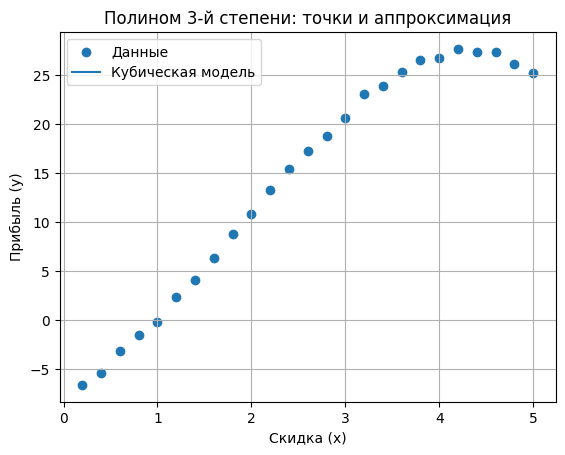

In [11]:
# === Кубическая модель ===
idx_c = pick_unique_support(x, y, k=4)  # вместо pick_indices_cubic(n)
coefs_c = solve_poly_by_points_from_indices(x, y, idx_c, degree=3)
y_fit_c = eval_poly_cubic(coefs_c, x)
rss_c = rss(y, y_fit_c)

print('Опорные индексы куба:', idx_c)
print('Опорные точки (x,y) для кубика:', list(zip(x[idx_c], y[idx_c])))
print('Коэффициенты [a3, a2, a1, a0]:', coefs_c)
print('RSS (кубический):', rss_c)

plt.figure()
plt.scatter(x, y, label='Данные')
xx = np.linspace(x.min(), x.max(), 400)
plt.plot(xx, eval_poly_cubic(coefs_c, xx), label='Кубическая модель')
plt.xlabel('Скидка (x)')
plt.ylabel('Прибыль (y)')
plt.title('Полином 3-й степени: точки и аппроксимация')
plt.legend()
plt.grid(True)
plt.show()

## 5. Сравнение моделей и прогнозы при x = 6% и x = 8%

In [13]:
def safe_rss(y_true, y_pred):
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    n_all = y_true.size
    n_used = mask.sum()
    if n_used == 0:
        # нет валидных точек для оценки ошибки
        return np.inf, n_all, n_used
    return float(np.sum((y_true[mask] - y_pred[mask])**2)), n_all, n_used

In [14]:
# --- после получения y_fit_q и y_fit_c ---
rss_q, n_all_q, n_used_q = safe_rss(y, y_fit_q)
rss_c, n_all_c, n_used_c = safe_rss(y, y_fit_c)

# сделаем выбор без NaN: любые NaN -> +inf
rss_q_cmp = np.inf if not np.isfinite(rss_q) else rss_q
rss_c_cmp = np.inf if not np.isfinite(rss_c) else rss_c

best_is_quad = rss_q_cmp <= rss_c_cmp
best_name = 'квадратичная' if best_is_quad else 'кубическая'
best_rss = rss_q if best_is_quad else rss_c

print(f"RSS (квадратичный): {rss_q}  | использовано точек: {n_used_q}/{n_all_q}")
print(f"RSS (кубический):   {rss_c}  | использовано точек: {n_used_c}/{n_all_c}")
print(f"Лучшая модель по RSS: {best_name} (RSS = {best_rss})")

RSS (квадратичный): 120.78752609259324  | использовано точек: 25/26
RSS (кубический):   1.878351450945749  | использовано точек: 25/26
Лучшая модель по RSS: кубическая (RSS = 1.878351450945749)


In [15]:
x_pred = np.array([6.0, 8.0])
y_pred = eval_poly_quad(coefs_q, x_pred) if best_is_quad else eval_poly_cubic(coefs_c, x_pred)
for xi, yi in zip(x_pred, y_pred):
    print(f"Ожидаемая прибыль при скидке {xi:.0f}% ≈ {yi:.6g}")

Ожидаемая прибыль при скидке 6% ≈ 13.0762
Ожидаемая прибыль при скидке 8% ≈ -56.3602


## 7. Выводы
- Построены модели второй и третьей степени по равномерно выбранным опорным точкам.
- Коэффициенты получены решением СЛУ (`scipy.linalg.solve` или `numpy.linalg.solve`).
- Значения RSS позволяют выбрать лучшую модель.
- Для лучшей модели получены прогнозы прибыли при скидках 6% и 8%.
- При желании можно варьировать опорные точки и анализировать влияние на RSS.